In [4]:
import numpy as np
from deap import base, creator, tools, algorithms
import random

# 初始化DEAP框架的基本参数
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # 设定为最大化问题
creator.create("Individual", list, fitness=creator.FitnessMax)  # 个体类型是列表

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, total_power / 6)  # 属性生成器，确保初始值较小
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, 6)  # 个体由6个属性组成
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # 种群由个体组成

# 适应度函数
def evaluate(individual):
    # 确保无负功率
    individual = [max(0, x) for x in individual]
    # 修正总功率
    if sum(individual) > total_power:
        individual = [x * total_power / sum(individual) for x in individual]

    rates = np.zeros(4)
    eavesdropper_rates = np.zeros(2)
    total_power_transmitted = sum(individual)

    for i in range(4):  # 正常用户
        interference = total_power_transmitted - individual[i]
        SINR = individual[i] * channel_gains[i] / (interference + noise_power)
        rates[i] = np.log2(1 + SINR) if SINR > 0 else 0

    for i in range(2):  # 窃听者
        interference = total_power_transmitted - individual[i+4]
        SINR = individual[i+4] * channel_gains[i+4] / (interference + noise_power)
        eavesdropper_rates[i] = np.log2(1 + SINR) if SINR > 0 else 0

    secure_rates = rates - np.max(eavesdropper_rates)
    total_secure_rate = np.sum(secure_rates)
    return (total_secure_rate,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 交叉操作
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)  # 变异操作，减小变异强度
toolbox.register("select", tools.selTournament, tournsize=3)  # 选择操作

# 约束检查
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator

toolbox.decorate("mate", checkBounds(0, total_power / 6))
toolbox.decorate("mutate", checkBounds(0, total_power / 6))

# 创建初始种群
population = toolbox.population(n=50)

# 运行遗传算法
result, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=True)

# 输出结果
best_ind = tools.selBest(result, 1)[0]
print("最优功率分配：", best_ind)
print("最大化的总安全容量：", evaluate(best_ind)[0])


gen	nevals
0  	50    
1  	37    
2  	31    
3  	35    
4  	33    
5  	33    
6  	29    
7  	33    
8  	28    
9  	28    
10 	28    
11 	32    
12 	32    
13 	33    
14 	29    
15 	34    
16 	25    
17 	32    
18 	26    
19 	32    
20 	32    
21 	33    
22 	33    
23 	20    
24 	32    
25 	28    
26 	33    
27 	27    
28 	31    
29 	28    
30 	34    
31 	30    
32 	29    
33 	23    
34 	35    
35 	28    
36 	30    
37 	33    
38 	27    
39 	25    
40 	35    
最优功率分配： [4.332336368337929, 4.268070523817497, 4.299501802183395, 3.8166967805496137, 0, 0]
最大化的总安全容量： 25.388632838419962


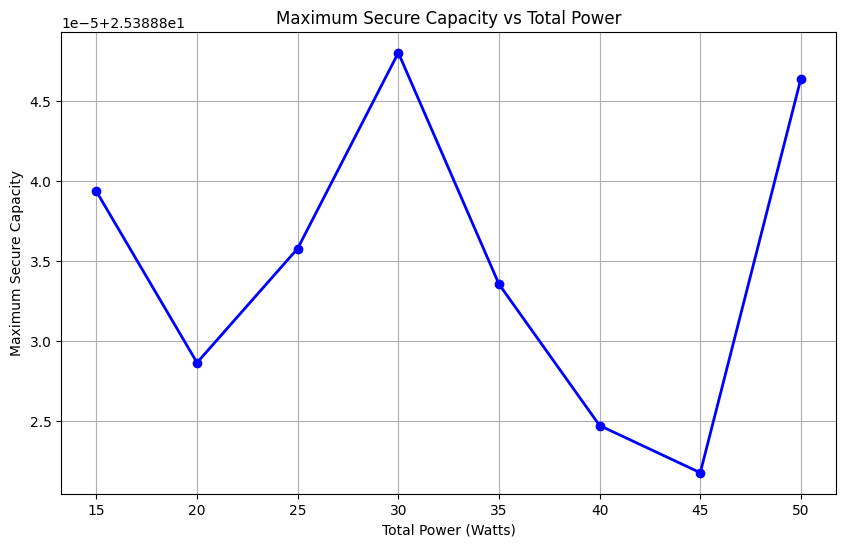

In [11]:
import numpy as np
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

# 系统参数
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# 初始化DEAP框架的基本参数
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# 适应度函数
def evaluate(individual):
    individual = [max(0, min(x, total_power / 2)) for x in individual]  # 确保无负功率且不超过上限
    if sum(individual) > total_power:
        individual = [x * total_power / sum(individual) for x in individual]
    rates = np.zeros(4)
    eavesdropper_rates = np.zeros(2)
    total_power_transmitted = sum(individual)
    for i in range(4):  # 正常用户
        interference = max(total_power_transmitted - individual[i], noise_power)  # 保证干扰大于噪声功率
        SINR = individual[i] * channel_gains[i] / interference
        rates[i] = np.log2(1 + SINR) if SINR > 0 else 0
    for i in range(2):  # 窃听者
        interference = max(total_power_transmitted - individual[i+4], noise_power)
        SINR = individual[i+4] * channel_gains[i+4] / interference
        eavesdropper_rates[i] = np.log2(1 + SINR) if SINR > 0 else 0
    secure_rates = rates - np.max(eavesdropper_rates)  # 减去最大的窃听者率
    total_secure_rate = np.sum(secure_rates)
    return (total_secure_rate,)

toolbox.register("attr_float", random.uniform, 0, 5)  # 控制初始值大小
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=total_power / 2, eta=20.0, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# 收集结果
secure_capacities = []

total_power_range = np.arange(15, 51, 5)
for total_power in total_power_range:
    population = toolbox.population(n=100)  # 增加种群大小
    result, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, verbose=False)  # 增加代数
    best_ind = tools.selBest(result, 1)[0]
    secure_capacities.append(evaluate(best_ind)[0])

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(total_power_range, secure_capacities, 'bo-', linewidth=2, markersize=6)
plt.title('Maximum Secure Capacity vs Total Power')
plt.xlabel('Total Power (Watts)')
plt.ylabel('Maximum Secure Capacity')
plt.grid(True)
plt.show()
